## Stochastic Gradient Descent (SGD)

### Load Dataset from sklearn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

In [6]:
from sklearn.datasets import fetch_california_housing

california = fetch_california_housing()

In [8]:
df = pd.DataFrame(california.data, columns=california.feature_names)
df['Target'] = california.target

df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894


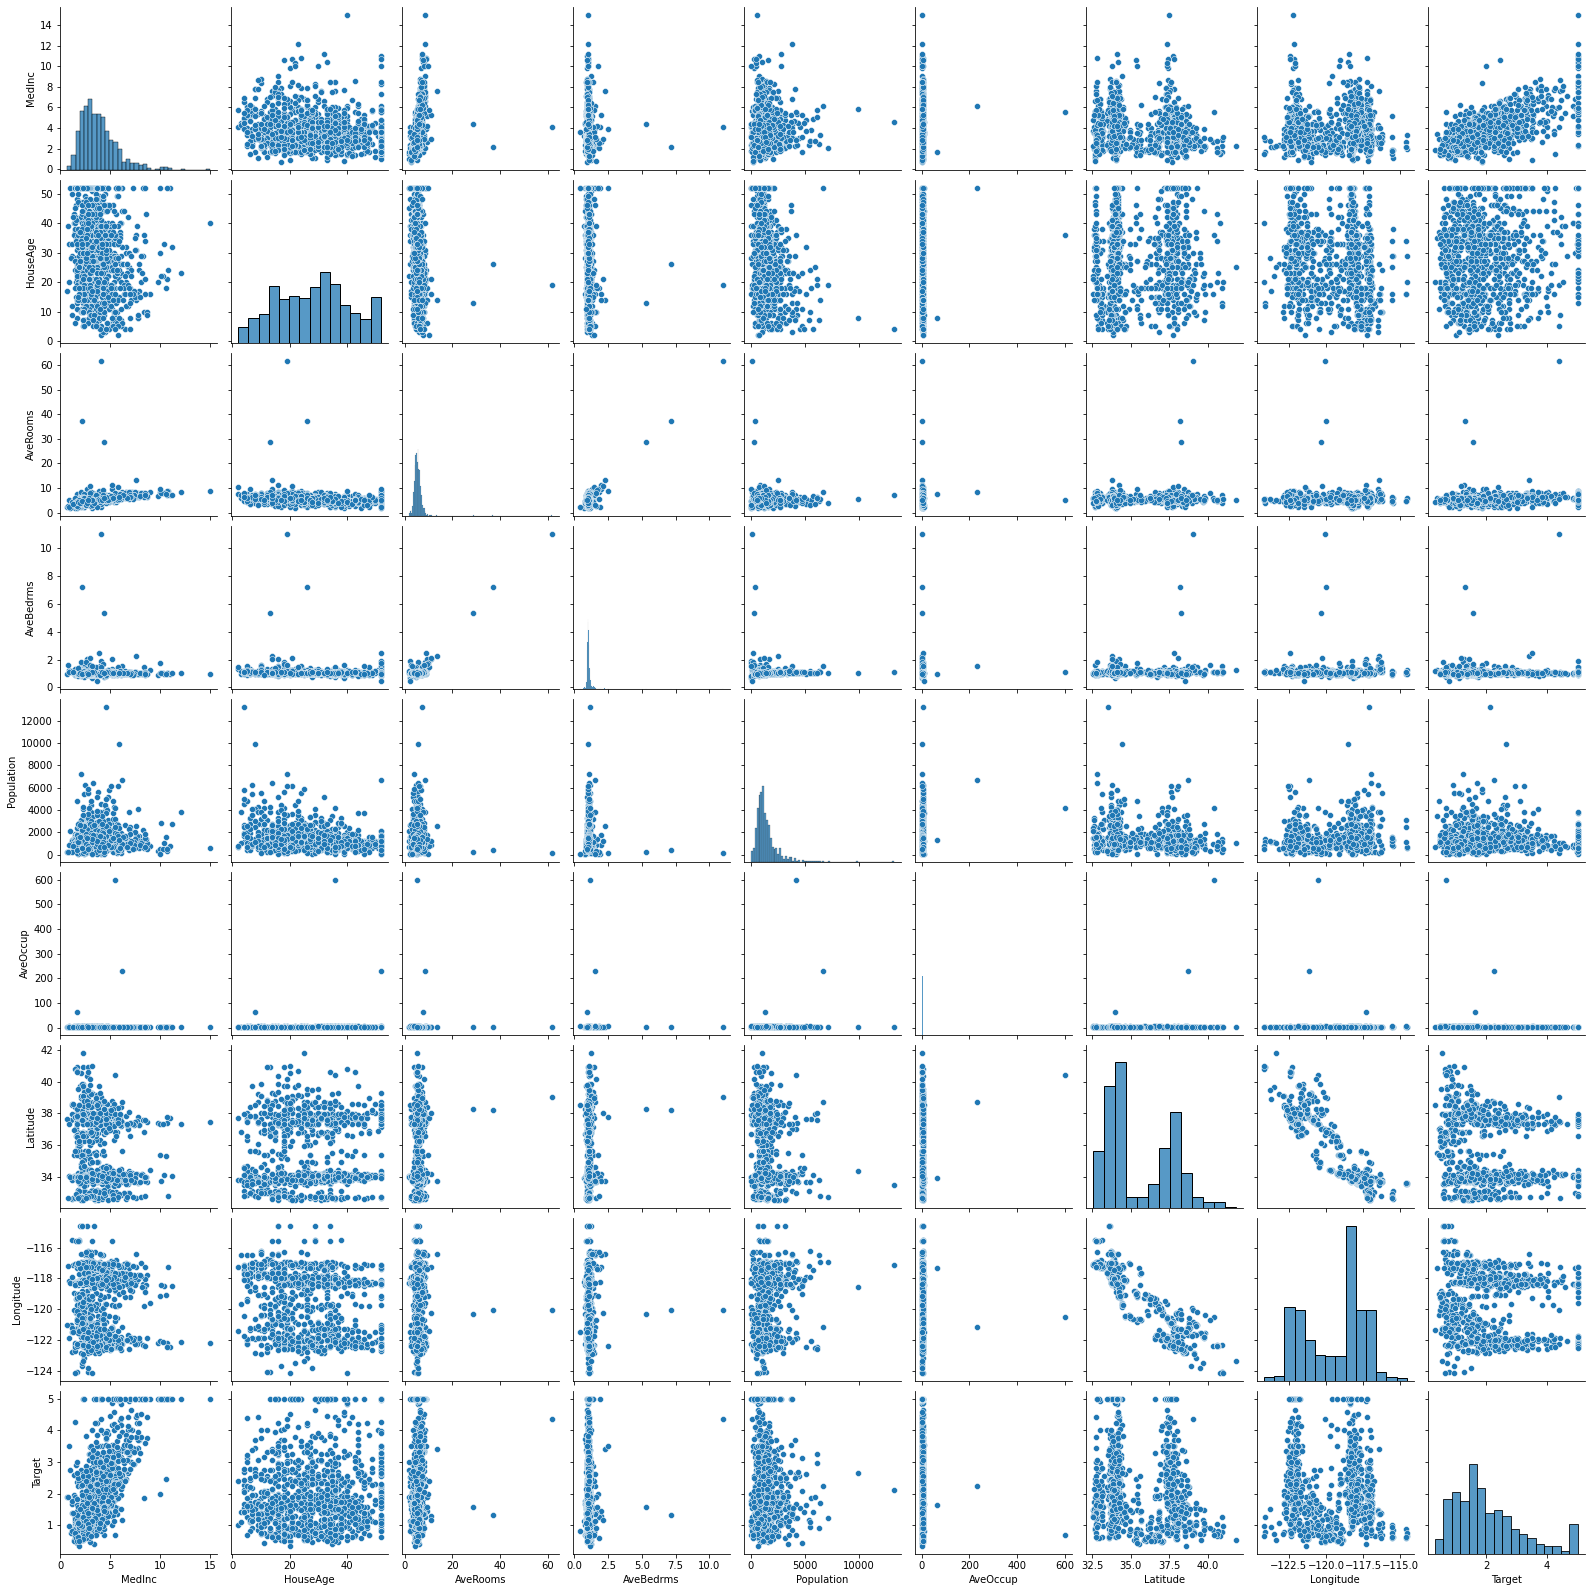

In [9]:
sns.pairplot(df.sample(1000))
plt.show()

In [ ]:
scaler = StandardScaler()
df.values[:, :-1] = scaler.fit_transform(df.values[:, :-1])
df

---

## Train Model with PyTorch

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [12]:
data = torch.from_numpy(df.values).float()

data.shape

torch.Size([20640, 9])

In [13]:
X = data[:, :-1]
y = data[:, -1:]

print(X.shape, y.shape)

torch.Size([20640, 8]) torch.Size([20640, 1])


In [14]:
n_epochs = 4000
batch_size = 256
print_interval = 200
learning_rate = 1e-2

---

## Build Models

In [15]:
## using Sequential

model = nn.Sequential(
    nn.Linear(X.size(-1), 6),
    nn.LeakyReLU(),
    nn.Linear(6, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 4),
    nn.LeakyReLU(),
    nn.Linear(4, 3),
    nn.LeakyReLU(),
    nn.Linear(3, y.size(-1)),
)

model

Sequential(
  (0): Linear(in_features=8, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)

In [16]:
optimizer = optim.SGD(model.parameters(), 
                      lr=learning_rate)

In [17]:
# |x| = (total_size, input_dim)
# |y| = (total_size, output_dim)

for i in range(n_epochs):
    #Shuffle the index to feed-forward.
    indices = torch.randperm(X.size(0))
    X_ = torch.index_select(X, dim=0, index=indices)
    y_ = torch.index_select(y, dim=0, index=indices)
    
    X_ = X_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    # |X_[i]| = (batch_size, input_dim)
    # |y_[i]| = (batch_size, output_dim)
    
    y_hat = []
    total_loss = 0
    
    for X_i, y_i in zip(X_, y_):
        # |X_i| = |X_[i]|
        # |y_i| = |y_[i]|
        
        y_hat_i = model(X_i)
        loss = F.mse_loss(y_hat_i, y_i)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        total_loss += float(loss)
        y_hat += [y_hat_i]
        
    total_loss = total_loss / len(X_)
    if (i + 1) % print_interval == 0:
        print('Epoch %d: loss=%.4e' % (i + 1, total_loss))


Epoch 200: loss=3.3192e-01
Epoch 400: loss=3.1373e-01
Epoch 600: loss=3.0839e-01
Epoch 800: loss=3.0023e-01
Epoch 1000: loss=2.9817e-01
Epoch 1200: loss=2.9543e-01
Epoch 1400: loss=2.9422e-01
Epoch 1600: loss=2.9352e-01
Epoch 1800: loss=2.9257e-01
Epoch 2000: loss=2.9195e-01
Epoch 2200: loss=2.9237e-01
Epoch 2400: loss=2.9101e-01
Epoch 2600: loss=2.9052e-01
Epoch 2800: loss=2.9076e-01
Epoch 3000: loss=2.9054e-01
Epoch 3200: loss=2.9124e-01
Epoch 3400: loss=2.9011e-01
Epoch 3600: loss=2.9023e-01
Epoch 3800: loss=2.8887e-01
Epoch 4000: loss=2.8988e-01


In [20]:
y_hat = torch.cat(y_hat, dim=0)
# |y_hat| = (total_size, output_dim)

In [23]:
y = torch.cat(y_, dim=0)
# |y| = (total_size, output_dim)

---

## Result

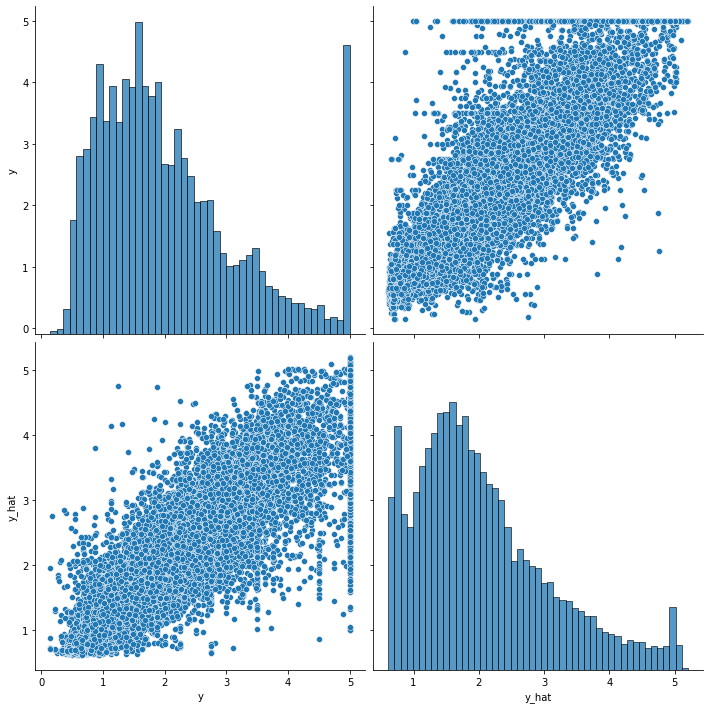

In [24]:
df = pd.DataFrame(torch.cat([y, y_hat], dim=1).detach().numpy(),
                  columns=["y", "y_hat"])

sns.pairplot(df, height=5)
plt.show()